<a target="_blank" href="https://colab.research.google.com/github/ashkan-mokarian/d2l-pytorch/blob/main/chapter_transformer/1_attention.ipynb">
  <img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/>
</a>

In [ ]:
%pip install d2l==1.0.0a0

In [8]:
import torch
from torch import nn
from torch.nn import functional as F
from d2l import torch as d2l
d2l.use_svg_display()

# Attention Pooling

## Heatmap visualization

In [6]:
def show_heatmaps(matrices, xlabel, ylabel, title=None, figsize=(2.5, 2.5), cmap="Reds"):
    """Show heatmap of matrices.

    Args:
        matrices: attention weights of shape (num_rows, num_cols, number of queries, number of keys).
    """
    d2l.use_svg_display()
    num_rows, num_cols, _, _ = matrices.shape
    fig, axes = d2l.plt.subplots(num_rows, num_cols, figsize=figsize,
                                 sharex=True, sharey=True, squeeze=False)
    for i, (row_axes, row_matrices) in enumerate(zip(axes, matrices)):
        for j, (ax, mat) in enumerate(zip(row_axes, row_matrices)):
            pcm = ax.imshow(mat.detach().numpy(), cmap=cmap)
            if i == num_rows-1:
                ax.set_xlabel(xlabel)
            if j == 0:
                ax.set_ylabel(ylabel)
            if title:
                ax.set_title(title[j])
    fig.colorbar(pcm, ax=axes, shrink=0.6)


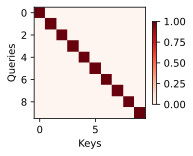

In [7]:
attention_weights = torch.eye(10).reshape(1, 1, 10, 10)
show_heatmaps(attention_weights, xlabel="Keys", ylabel="Queries")

## Nadaraya-Watson Regression using attention pooling
Here, $\mathbf{v_i}=y_i$ are targets, $\bf x_i=k_i$ are features, and $q_i$ is the location where function f should be evaluated.

Several different kernels could be used:

* $Gaussian: α(q,k) = \exp (-\frac{1}{2}||q-k||^2)$
* Boxcar: $α(q,k) = 1 if ||q-k||\leq 1$
* Epanechikov: $α(q,k) = max(0, 1-||q-k||)$

This is a simple example and we take q and k to be scalar and k=0 the origin.

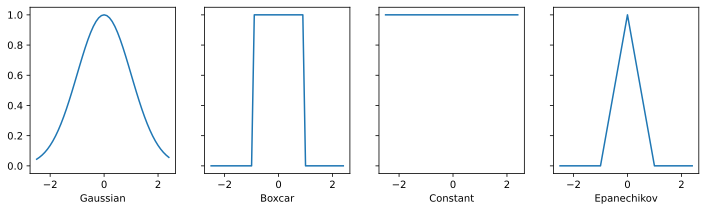

In [11]:
fig, axes = d2l.plt.subplots(1, 4, sharey=True, figsize=(12, 3))

# Define some kernels
def gaussian(x):
    return torch.exp(-x**2 / 2)

def boxcar(x):
    return torch.abs(x) < 1.0

def constant(x):
    return 1.0 + 0 * x

def epanechikov(x):
    return torch.max(1 - torch.abs(x), torch.zeros_like(x))

kernels = (gaussian, boxcar, constant, epanechikov)
names = ("Gaussian", "Boxcar", "Constant", "Epanechikov")
x = torch.arange(-2.5, 2.5, 0.1)
for kernel, name, ax in zip(kernels, names, axes):
    ax.plot(x.detach().numpy(), kernel(x).detach().numpy())
    ax.set_xlabel(name)

In [12]:
# Preparing Data for task y=2*sin(x) + x + eps
def f(x):
    return 2 * torch.sin(x) + x

n = 40  # num train examples
x_train, _ = torch.sort(torch.rand(n) * 5)
y_train = f(x_train) + torch.randn(n)
x_val = torch.arange(0, 5, 0.1)
y_val = f(x_val)

In this simple model, we want to predict target values for validation data based on training data by using kernels as similarity measures. Hence query is x_val, and training feature-label pairs are key-value pairs. The normalized attention weights is computed as follows.

In [17]:
def nadaraya_watson(x_train, y_train, x_val, kernel):
    dists = x_train.reshape((-1, 1)) - x_val.reshape((1, -1))
    # Each column/row corresponds to each query/key
    k = kernel(dists)
    # Normalize for each query
    attention_w = k/k.sum(0)
    y_hat = y_train@attention_w
    return y_hat, attention_w

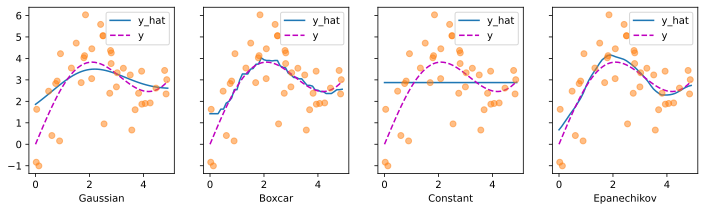

In [18]:
def plot(x_train, y_train, x_val, y_val, kernels, names, attention=False):
    fig, axes = d2l.plt.subplots(1, 4, sharey=True, figsize=(12, 3))
    for kernel, name, ax in zip(kernels, names, axes):
        y_hat, attention_w = nadaraya_watson(x_train, y_train, x_val, kernel)
        if attention:
            pcm = ax.imshow(attention_w.detach().numpy(), cmap='Reds')
        else:
            ax.plot(x_val, y_hat)
            ax.plot(x_val, y_val, 'm--')
            ax.plot(x_train, y_train, 'o', alpha=0.5);
        ax.set_xlabel(name)
        if not attention:
            ax.legend(['y_hat', 'y'])
    if attention:
        fig.colorbar(pcm, ax=axes, shrink=0.7)

plot(x_train, y_train, x_val, y_val, kernels, names)

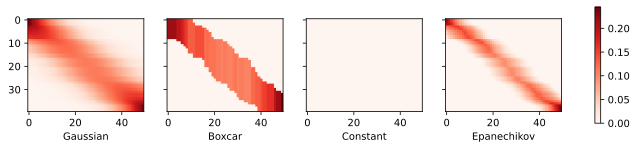

In [19]:
plot(x_train, y_train, x_val, y_val, kernels, names, attention=True)

This is one of the earliest methods with attention mechanism. Here, the kernel functions are handcrafted. One can add sigma to the gaussian and change the window of attention. There can be more clever ideas, e.g. choosing the window based on the density of data at that point, However, in transformers we will learn these.

# Attention Scoring Functions in Transformers
It turns out that computing scores (matrix-multiplication) is simpler and faster than distances. Hence kernels in transformers are scoring functions between query-keys followed by a softmax.

### Masked softmax
A convenience function to implement variable length of sequences in a minibatch by padding by special tokens but not considering them in attention pooling.

In [45]:
def masked_softmax(X, valid_len):
    """Masked softmax.

    Args:
        X: 3D Tensor
        valid_lens: 1D or 2D
    """
    def _sequence_mask(X, valid_len, value=0):
        maxlen = X.size(1)
        mask = torch.arange(maxlen, dtype=torch.float32,
                            device=X.device)[None, :] < valid_len[:, None]
        # print(mask)
        X[~mask] = value
        return X
    
    if valid_len is None:
        return F.softmax(X, dim=-1)
    else:
        shape = X.shape
        if valid_len.dim() == 1:
            valid_len = torch.repeat_interleave(valid_len, shape[1])
        else:
            valid_len = valid_len.reshape(-1)
        X = _sequence_mask(X.reshape(-1, shape[-1]), valid_len, value=-1e6)
        return F.softmax(X.reshape(shape), -1)

print(masked_softmax(torch.randn((2, 2, 4)), torch.tensor([2, 3])))
print(masked_softmax(torch.rand(2, 2, 4), torch.tensor([[1, 3], [2, 4]])))

tensor([[[0.7495, 0.2505, 0.0000, 0.0000],
         [0.2405, 0.7595, 0.0000, 0.0000]],

        [[0.5301, 0.2001, 0.2698, 0.0000],
         [0.2526, 0.5940, 0.1535, 0.0000]]])
tensor([[[1.0000, 0.0000, 0.0000, 0.0000],
         [0.2695, 0.3913, 0.3392, 0.0000]],

        [[0.5309, 0.4691, 0.0000, 0.0000],
         [0.1682, 0.3132, 0.2121, 0.3066]]])


## Dot-product attention

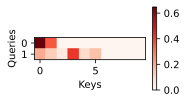

In [49]:
class DotProductAttention(nn.Module):
    def __init__(self, dropout):
        super().__init__()
        self.dropout = nn.Dropout(dropout)
    
    def forward(self, queries, keys, values, valid_len=None):
        """
        Args:
            queries: of shape (batch_size, no. of queries, d)
            keys:    of shape (batch_size, no. of key-value pairs, d)
            values:  of shape (batch_size, no. of key-value pairs, value dimension)
            valid_len:of shape (batch_size) or (batch_size, no. of queries)
        """
        d = queries.shape[-1]
        # swap last two dimensions of keys to get correct shapes for batch matric multiplication
        scores = torch.bmm(queries, keys.transpose(1, 2)) / torch.sqrt(torch.tensor(d))
        self.attention_weights = masked_softmax(scores, valid_len)
        return torch.bmm(self.dropout(self.attention_weights), values)


# Test
queries = torch.normal(0, 1, (2, 1, 2))
keys = torch.normal(0, 1, (2, 10, 2))
values = torch.normal(0, 1, (2, 10, 4))
valid_lens = torch.tensor([2, 6])

attention = DotProductAttention(dropout=0.5)
attention.eval()
d2l.check_shape(attention(queries, keys, values, valid_lens), (2, 1, 4))

d2l.show_heatmaps(attention.attention_weights.reshape((1, 1, 2, 10)),
                  xlabel='Keys', ylabel='Queries')

## Additive attention

/usr/local/lib/python3.10/dist-packages/torch/nn/modules/lazy.py:180: UserWarning: Lazy modules are a new feature under heavy development so changes to the API or functionality can happen at any moment.
  warnings.warn('Lazy modules are a new feature under heavy development '


torch.Size([2, 1, 10, 8]) torch.Size([2, 1, 8]) torch.Size([2, 10, 8])
torch.Size([2, 1, 10, 1])


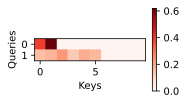

In [54]:
class AdditiveAttention(nn.Module):
    def __init__(self, num_hiddens, dropout, **kwargs):
        super(AdditiveAttention, self).__init__(**kwargs)
        self.W_q = nn.LazyLinear(num_hiddens, bias=False)
        self.W_k = nn.LazyLinear(num_hiddens, bias=False)
        self.w_v = nn.LazyLinear(1, bias=False)
        self.dropout = nn.Dropout(dropout)
    
    def forward(self, queries, keys, values, valid_len=None):
        queries, keys = self.W_q(queries), self.W_k(keys)
        # Dimension expansion for broadcasting
        features = queries.unsqueeze(2) + keys.unsqueeze(1)
        print(features.shape, queries.shape, keys.shape)
        features = torch.tanh(features)
        scores = self.w_v(features)
        print(scores.shape)
        scores = scores.squeeze(-1)
        self.attention_weights = masked_softmax(scores, valid_len)
        return torch.bmm(self.dropout(self.attention_weights), values)

queries = torch.normal(0, 1, (2, 1, 20))
attention = AdditiveAttention(num_hiddens=8, dropout=0.1)
attention.eval()
d2l.check_shape(attention(queries, keys, values, valid_lens), (2, 1, 4))

d2l.show_heatmaps(attention.attention_weights.reshape((1, 1, 2, 10)),
                  xlabel='Keys', ylabel='Queries')